# Library

In [49]:
# !python -m pip install keras-tuner
# !python -m pip install tensorflow_hub

In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras_tuner as kt
import imghdr

from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.python.client import device_lib
from platform import python_version


In [3]:
print("Using Tensorflow version: ", tf.__version__)
print("Using Python version: ", python_version())
print(tf.config.list_physical_devices())

if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
    print(device_lib.list_local_devices())
else:
    print("No GPU Device")

Using Tensorflow version:  2.9.0
Using Python version:  3.8.13
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device:/device:GPU:0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2045566050569540183
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2004588955
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7705064095189860749
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


# Param

In [4]:
BATCH_SIZE = 32

IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

DATA_DIR = "./Datasets"

EPOCH = 1000

seed=123

# Load & Preprocessing Images

### Checking if Image is Valid

In [5]:
# Image Extenstions that we will use
image_extensions = [".png", ".jpg"]

# Image Type that Tensorflow support
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(DATA_DIR).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image, removing image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow, removing image")
            os.remove(filepath)

### Data Augmentation

In [8]:
train_datagen = ImageDataGenerator(
     rescale=1./255,
     rotation_range=40,
     width_shift_range=0.2,
     height_shift_range=0.2,
     shear_range=0.2,
     zoom_range=0.2,
     horizontal_flip=True,
     fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2
)

train_datagen = train_datagen.flow_from_directory(
        DATA_DIR, 
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=32,
        subset="training",
        class_mode='categorical',
        seed=123,
)

validation_datagen = validation_datagen.flow_from_directory(
        DATA_DIR,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=32,
        subset="validation",
        class_mode='categorical',
        seed=123
)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dategen = train_datagen.prefetch(buffer_size=AUTOTUNE)

label_map = (train_datagen.class_indices)
print(label_map)

Found 2591 images belonging to 21 classes.
Found 511 images belonging to 21 classes.
{'culture-rumah-gadang-minangkabau': 0, 'kue-dadar-gulung': 1, 'kue-kastengel': 2, 'kue-klepon': 3, 'kue-lapis': 4, 'kue-lumpur': 5, 'kue-putri-salju': 6, 'kue-risoles': 7, 'kue-serabi': 8, 'landmark-borobudur': 9, 'landmark-candi-prambanan': 10, 'landmark-gedung-sate': 11, 'landmark-gwk': 12, 'landmark-jam-gadang': 13, 'landmark-masjid-raya-baiturrahman': 14, 'landmark-menara-kudus': 15, 'landmark-monas': 16, 'landmark-patung-suroboyo': 17, 'landmark-pura-tanah-lot': 18, 'landmark-tugu-khatulistiwa': 19, 'landmark-tugu-yogyakarta': 20}


### Validation Image Example

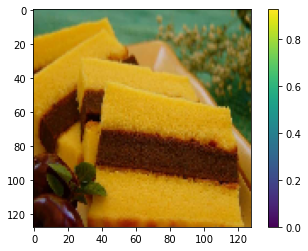

kue-lapis


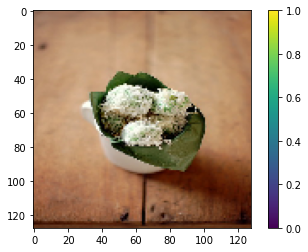

kue-klepon


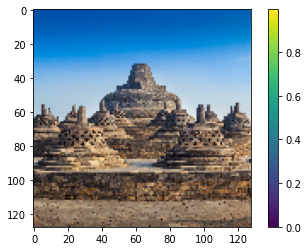

landmark-borobudur


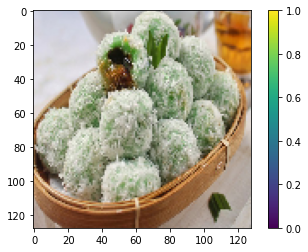

kue-klepon


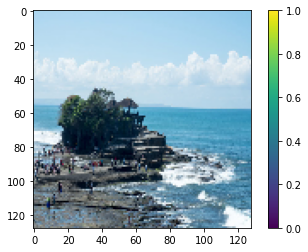

landmark-pura-tanah-lot


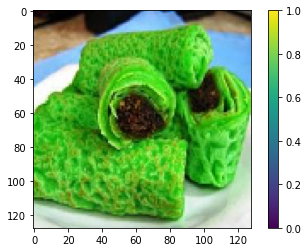

kue-dadar-gulung


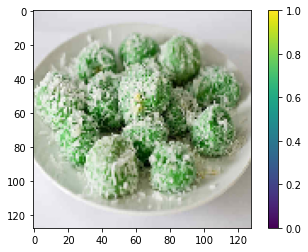

kue-klepon


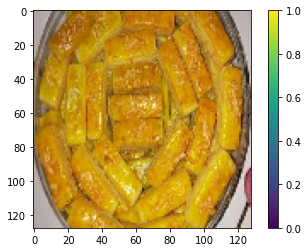

kue-kastengel


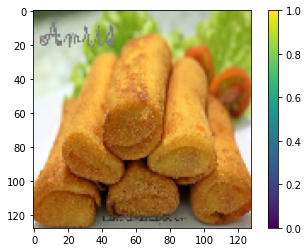

kue-risoles


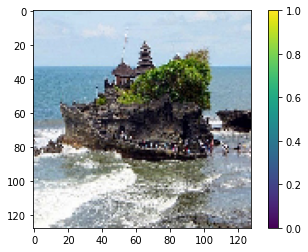

landmark-pura-tanah-lot


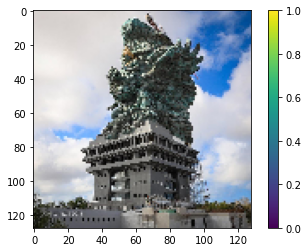

landmark-gwk


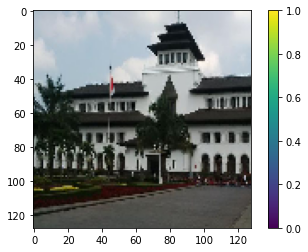

landmark-gedung-sate


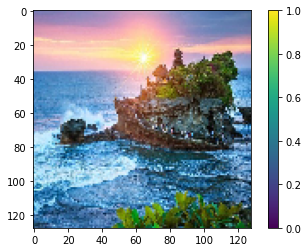

landmark-pura-tanah-lot


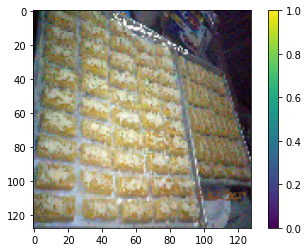

kue-kastengel


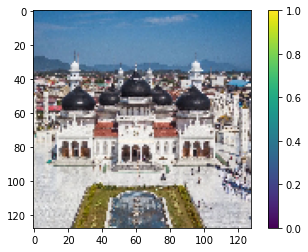

landmark-masjid-raya-baiturrahman


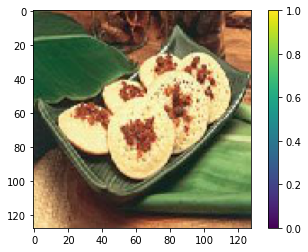

kue-serabi


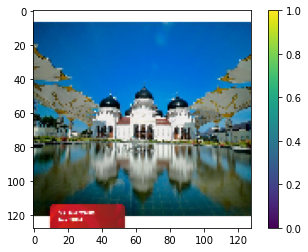

landmark-masjid-raya-baiturrahman


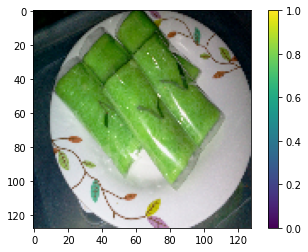

kue-dadar-gulung


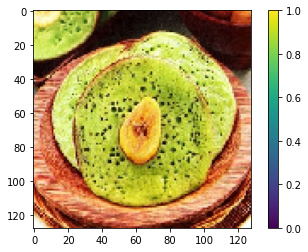

kue-serabi


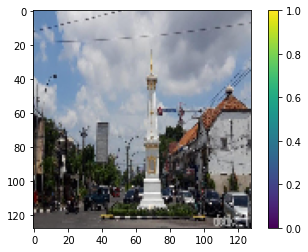

landmark-tugu-yogyakarta


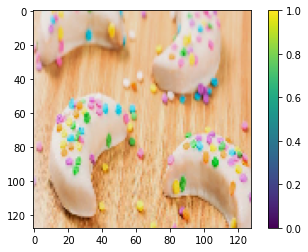

kue-putri-salju


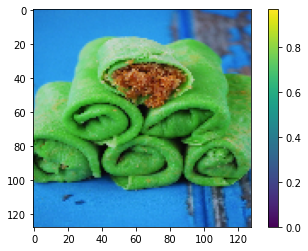

kue-dadar-gulung


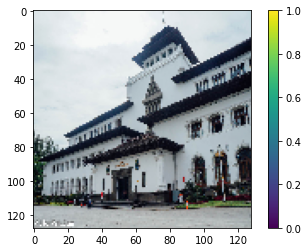

landmark-gedung-sate


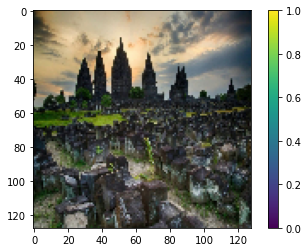

landmark-candi-prambanan


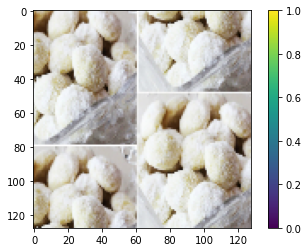

kue-putri-salju


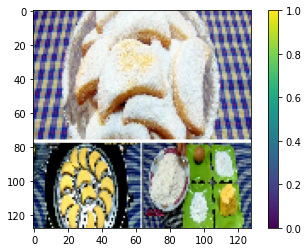

kue-putri-salju


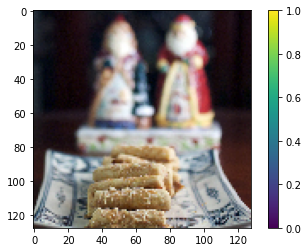

kue-kastengel


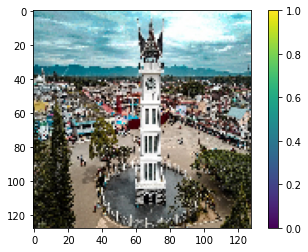

landmark-jam-gadang


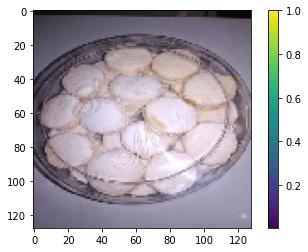

kue-putri-salju


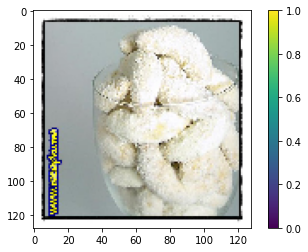

kue-putri-salju


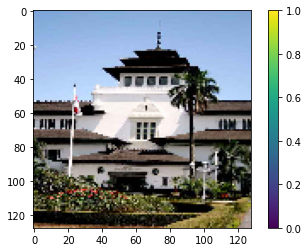

landmark-gedung-sate


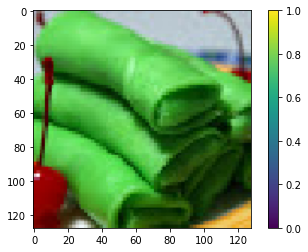

kue-dadar-gulung


In [84]:
for img in validation_datagen:
    images = img[0]
    labels = img[1]
    for i in range(len(labels)):
        label = img[1][i]
        plt.imshow((images[i]))
        plt.colorbar()
        plt.show()
        print(list(label_map.keys())[list(label_map.values()).index(label.argmax(axis=-1))])
        print("=====================================================")
    break


# Model

In [144]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 
                           (3,3), 
                           activation='relu', 
                           kernel_regularizer= tf.keras.regularizers.l2(0.01), 
                           padding="same",
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D(),
    
    tf.keras.layers.Conv2D(64, 
                           (3,3), 
                           activation='relu', 
                           kernel_regularizer= tf.keras.regularizers.l2(0.01), 
                           padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D(),
    
    tf.keras.layers.Conv2D(96, 
                           (3,3), 
                           activation='relu', 
                           kernel_regularizer= tf.keras.regularizers.l2(0.01), 
                           padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D(),
    
    tf.keras.layers.Conv2D(144, 
                           (3,3), 
                           activation='relu', 
                           kernel_regularizer= tf.keras.regularizers.l2(0.01), 
                           padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(label_map), activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              metrics=['accuracy']
             )

model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_44 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 average_pooling2d_22 (Avera  (None, 64, 64, 32)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_57 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_45 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                     

# Training Model

In [145]:
overfitCallback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience = 10)

checkpoint_filepath = './tmp/checkpoint/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') is not None and logs.get('acc') > 0.95:
            print("\nLoss is lower than 0.85 so cancelling training!")
            self.model.stop_training = True

thresholdCallbacks = myCallback()

In [146]:
history = model.fit(
    train_datagen,
    epochs=EPOCH,
    verbose=1,
    validation_data=validation_datagen,
    callbacks=[
        overfitCallback,
        model_checkpoint_callback,
        thresholdCallbacks
    ]
)

Epoch 1/1000
81/81 [==============================] - 105s 1s/step - loss: 4.8285 - accuracy: 0.2783 - val_loss: 5.3182 - val_accuracy: 0.0724
Epoch 2/1000
81/81 [==============================] - 97s 1s/step - loss: 4.1964 - accuracy: 0.3848 - val_loss: 5.1137 - val_accuracy: 0.1566
Epoch 3/1000
81/81 [==============================] - 96s 1s/step - loss: 3.8934 - accuracy: 0.4346 - val_loss: 5.1251 - val_accuracy: 0.1722
Epoch 4/1000
81/81 [==============================] - 96s 1s/step - loss: 3.6907 - accuracy: 0.4550 - val_loss: 4.8565 - val_accuracy: 0.1585
Epoch 5/1000
81/81 [==============================] - 94s 1s/step - loss: 3.4541 - accuracy: 0.4932 - val_loss: 4.2248 - val_accuracy: 0.3151
Epoch 6/1000
81/81 [==============================] - 93s 1s/step - loss: 3.3045 - accuracy: 0.5257 - val_loss: 3.7312 - val_accuracy: 0.3738
Epoch 7/1000
81/81 [==============================] - 93s 1s/step - loss: 3.0994 - accuracy: 0.5627 - val_loss: 3.5024 - val_accuracy: 0.5088
Epoch

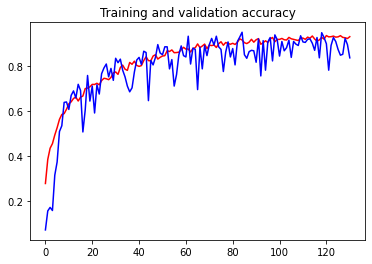

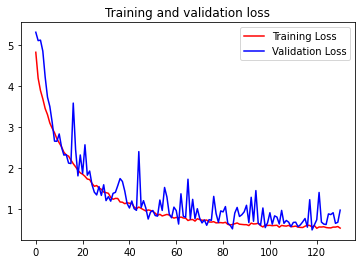

In [147]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Export

In [159]:
model.save("saved_model/3")

converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/3")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


In [160]:
tflite_model_file = Path('./saved_model/3/model.tflite')
tflite_model_file.write_bytes(tflite_model)

409904

## Testing

In [ ]:
model.load_weights("./tmp/checkpoint/")

In [154]:
model.summary()
print(model.evaluate(validation_datagen, verbose=2))

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_44 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 average_pooling2d_22 (Avera  (None, 64, 64, 32)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_57 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_45 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                     

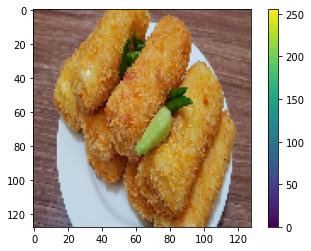

In [164]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()       

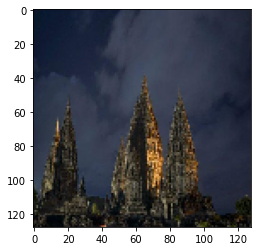

1/1 [==============================] - 0s 57ms/step
10
This image most likely belong to landmark-candi-prambanan with a 11.90 percent confidence


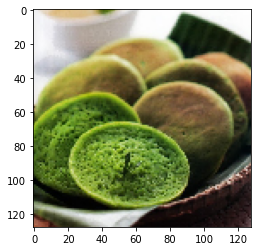

1/1 [==============================] - 0s 60ms/step
8
This image most likely belong to kue-serabi with a 11.55 percent confidence


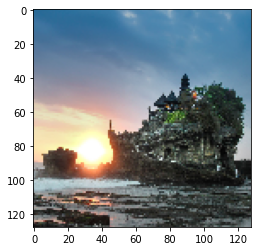

1/1 [==============================] - 0s 52ms/step
18
This image most likely belong to landmark-pura-tanah-lot with a 11.32 percent confidence


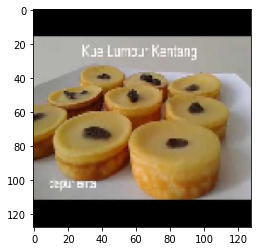

1/1 [==============================] - 0s 41ms/step
5
This image most likely belong to kue-lumpur with a 11.96 percent confidence


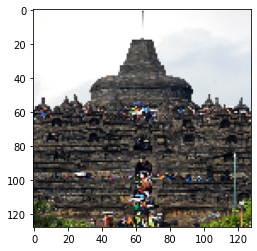

1/1 [==============================] - 0s 30ms/step
9
This image most likely belong to landmark-borobudur with a 11.80 percent confidence


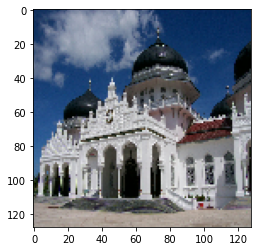

1/1 [==============================] - 0s 33ms/step
14
This image most likely belong to landmark-masjid-raya-baiturrahman with a 11.96 percent confidence


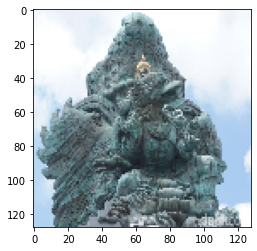

1/1 [==============================] - 0s 27ms/step
12
This image most likely belong to landmark-gwk with a 11.97 percent confidence


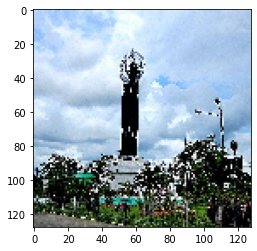

1/1 [==============================] - 0s 30ms/step
19
This image most likely belong to landmark-tugu-khatulistiwa with a 11.94 percent confidence


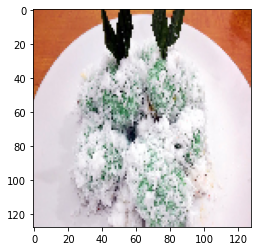

1/1 [==============================] - 0s 29ms/step
3
This image most likely belong to kue-klepon with a 11.96 percent confidence


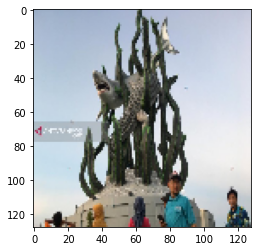

1/1 [==============================] - 0s 33ms/step
17
This image most likely belong to landmark-patung-suroboyo with a 11.96 percent confidence


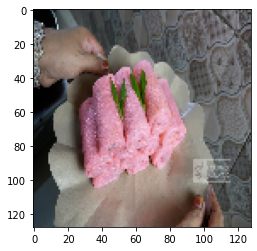

1/1 [==============================] - 0s 34ms/step
1
This image most likely belong to kue-dadar-gulung with a 11.96 percent confidence


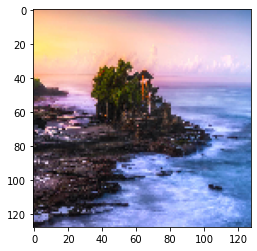

1/1 [==============================] - 0s 39ms/step
18
This image most likely belong to landmark-pura-tanah-lot with a 11.97 percent confidence


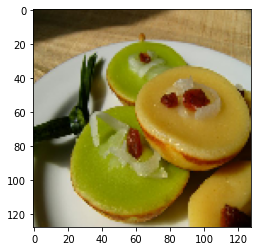

1/1 [==============================] - 0s 50ms/step
5
This image most likely belong to kue-lumpur with a 11.97 percent confidence


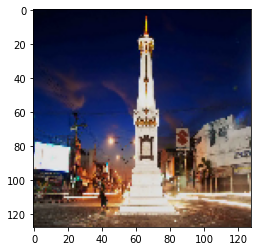

1/1 [==============================] - 0s 29ms/step
20
This image most likely belong to landmark-tugu-yogyakarta with a 11.95 percent confidence


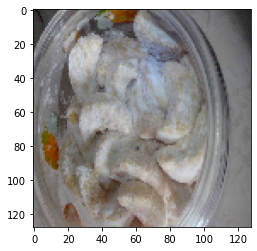

1/1 [==============================] - 0s 31ms/step
6
This image most likely belong to kue-putri-salju with a 11.97 percent confidence


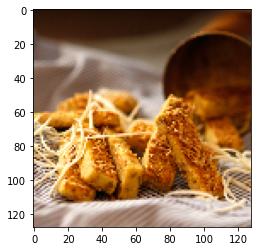

1/1 [==============================] - 0s 41ms/step
2
This image most likely belong to kue-kastengel with a 11.96 percent confidence


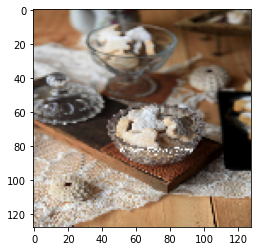

1/1 [==============================] - 0s 34ms/step
6
This image most likely belong to kue-putri-salju with a 11.78 percent confidence


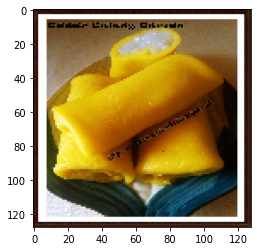

1/1 [==============================] - 0s 32ms/step
5
This image most likely belong to kue-lumpur with a 9.16 percent confidence


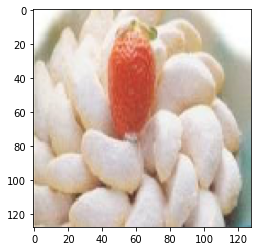

1/1 [==============================] - 0s 33ms/step
6
This image most likely belong to kue-putri-salju with a 11.96 percent confidence


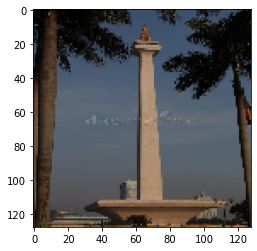

1/1 [==============================] - 0s 31ms/step
16
This image most likely belong to landmark-monas with a 11.96 percent confidence


In [166]:
img = tf.keras.utils.load_img(
    img_to_test, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT)
)

img = tf.keras.utils.img_to_array(img)
img = tf.expand_dims(img, 0)
class_names = dict((v,k) for k,v in label_map.items())

for _ in range(20):
    img, label = validation_datagen.next()
    plt.imshow(img[0])
    plt.show()
    predictions = model.predict(img)
    score = tf.nn.softmax(predictions[0])

    print(np.argmax(score))
    print("This image most likely belong to {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100 * np.max(score)))


In [161]:
new_model = tf.keras.models.load_model('saved_model/3')
new_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_44 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 average_pooling2d_22 (Avera  (None, 64, 64, 32)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_57 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_45 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                     

16/16 - 16s - loss: 0.5135 - accuracy: 0.9491 - 16s/epoch - 1s/step
Restored model, accuracy: 94.91%
1/1 [==============================] - 0s 29ms/step


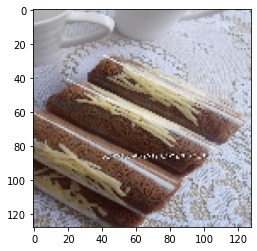

1/1 [==============================] - 0s 36ms/step
1
This image most likely belong to kue-dadar-gulung with a 11.89 percent confidence


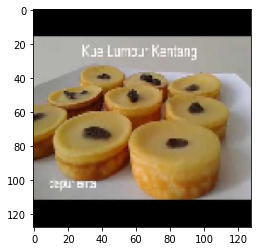

1/1 [==============================] - 0s 33ms/step
5
This image most likely belong to kue-lumpur with a 11.96 percent confidence


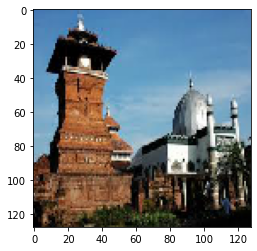

1/1 [==============================] - 0s 32ms/step
15
This image most likely belong to landmark-menara-kudus with a 11.97 percent confidence


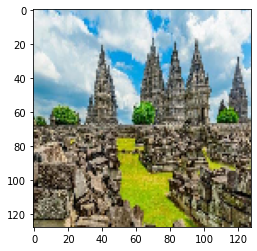

1/1 [==============================] - 0s 30ms/step
10
This image most likely belong to landmark-candi-prambanan with a 11.27 percent confidence


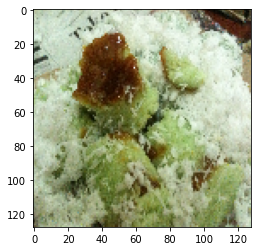

1/1 [==============================] - 0s 32ms/step
3
This image most likely belong to kue-klepon with a 11.95 percent confidence


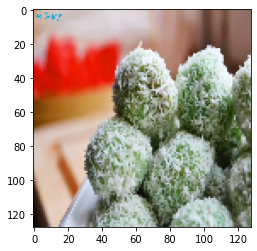

1/1 [==============================] - 0s 32ms/step
3
This image most likely belong to kue-klepon with a 11.97 percent confidence


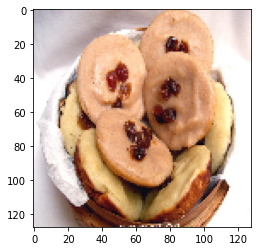

1/1 [==============================] - 0s 27ms/step
5
This image most likely belong to kue-lumpur with a 11.96 percent confidence


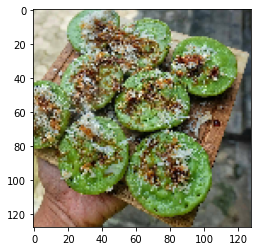

1/1 [==============================] - 0s 30ms/step
8
This image most likely belong to kue-serabi with a 9.58 percent confidence


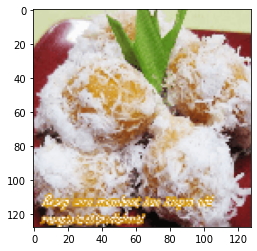

1/1 [==============================] - 0s 29ms/step
3
This image most likely belong to kue-klepon with a 11.97 percent confidence


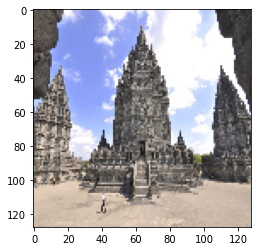

1/1 [==============================] - 0s 33ms/step
10
This image most likely belong to landmark-candi-prambanan with a 11.02 percent confidence


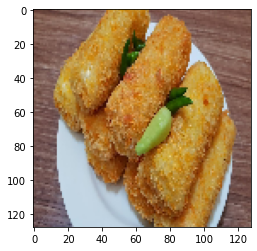

1/1 [==============================] - 0s 32ms/step
7
This image most likely belong to kue-risoles with a 11.93 percent confidence


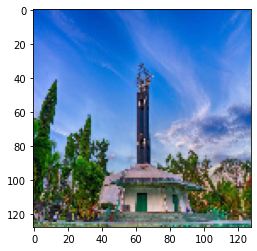

1/1 [==============================] - 0s 28ms/step
19
This image most likely belong to landmark-tugu-khatulistiwa with a 11.96 percent confidence


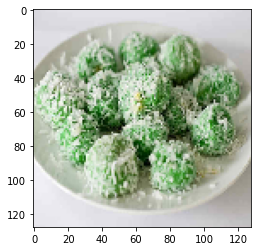

1/1 [==============================] - 0s 27ms/step
3
This image most likely belong to kue-klepon with a 11.97 percent confidence


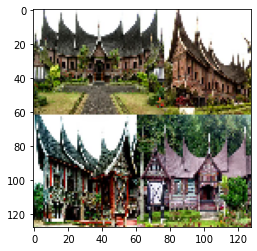

1/1 [==============================] - 0s 37ms/step
0
This image most likely belong to culture-rumah-gadang-minangkabau with a 11.92 percent confidence


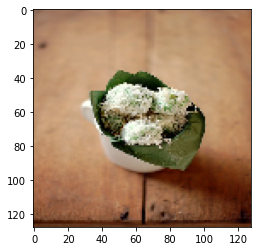

1/1 [==============================] - 0s 36ms/step
3
This image most likely belong to kue-klepon with a 11.08 percent confidence


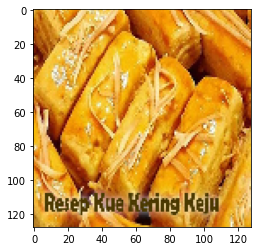

1/1 [==============================] - 0s 29ms/step
2
This image most likely belong to kue-kastengel with a 11.97 percent confidence


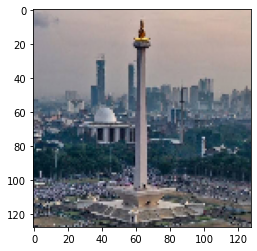

1/1 [==============================] - 0s 30ms/step
16
This image most likely belong to landmark-monas with a 11.85 percent confidence


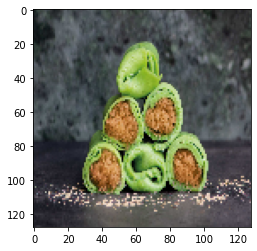

1/1 [==============================] - 0s 30ms/step
1
This image most likely belong to kue-dadar-gulung with a 11.90 percent confidence


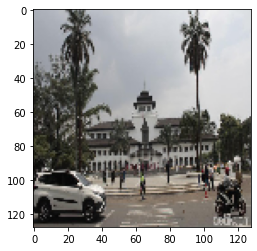

1/1 [==============================] - 0s 41ms/step
11
This image most likely belong to landmark-gedung-sate with a 9.89 percent confidence


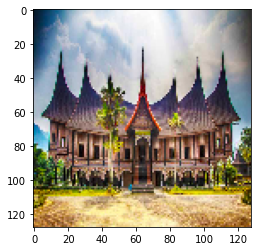

1/1 [==============================] - 0s 33ms/step
0
This image most likely belong to culture-rumah-gadang-minangkabau with a 11.97 percent confidence


In [168]:
loss, acc = new_model.evaluate(validation_datagen, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

new_model_predictions = new_model.predict(images)
new_model_score = tf.nn.softmax(new_model_predictions[0])
class_names = dict((v,k) for k,v in label_map.items())

for _ in range(20):
    img, label = validation_datagen.next()
    plt.imshow(img[0])
    plt.show()
    predictions = new_model.predict(img)
    score = tf.nn.softmax(predictions[0])

    print(np.argmax(score))
    print("This image most likely belong to {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100 * np.max(score)))
